# Exercice 4 : Regression

### Import des bibliothèques

In [34]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

### Import du dataset (train et test)

In [35]:
X_test = np.load("data/X_test.npy")
X_train = np.load("data/X_train.npy")
y_test = np.load("data/y_test.npy")
y_train = np.load("data/y_train.npy")

### Analyse du dataset

In [36]:
print(f"Forme des données d'entraînement: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Forme des données de test: X_test {X_test.shape}, y_test {y_test.shape}")

print("Statistiques descriptives de y_train:")
print(f"Moyenne: {np.mean(y_train):.4f}")
print(f"Écart-type: {np.std(y_train):.4f}")
print(f"Min: {np.min(y_train):.4f}")
print(f"Max: {np.max(y_train):.4f}")

Forme des données d'entraînement: X_train (200, 200), y_train (200, 1)
Forme des données de test: X_test (200, 200), y_test (200, 1)
Statistiques descriptives de y_train:
Moyenne: 4.9068
Écart-type: 0.9454
Min: 1.9300
Max: 7.4648


#### Analyse

Cette cellule permet de vérifier la structure et les caractéristiques de base des données utilisées pour l'entraînement et le test du modèle de régression. Les variables explicatives `X_train` et `X_test` sont des matrices de dimension (200, 200), ce qui signifie que chaque jeu contient 200 observations avec 200 variables explicatives. Les variables cibles `y_train` et `y_test` sont des vecteurs de taille (200, 1), ce qui indique qu’il s’agit d’un problème de régression univariée. Ensuite, quelques statistiques descriptives sont affichées pour `y_train`, notamment la moyenne (4.9068), l’écart-type (0.9454), le minimum (1.9300) et le maximum (7.4648). Ces statistiques donnent une première idée de la distribution de la variable cible sur l’ensemble d’entraînement et peuvent aider à détecter d’éventuelles valeurs aberrantes ou une asymétrie dans les données.

### Fonction objective

Étant donné la structure des données observée précédemment, avec un grand nombre de variables explicatives (200) pour un nombre modéré d’observations (200), il est préférable d’envisager des modèles de régression régularisée. En effet, dans ce type de situation, la présence potentielle de surapprentissage est importante. La régression Ridge et la régression ElasticNet sont deux approches classiques qui permettent d’introduire une pénalisation sur les coefficients du modèle afin d’améliorer la généralisation. Ridge est adaptée en cas de nombreuses variables corrélées, tandis qu’ElasticNet combine les avantages des régressions L1 (lasso) et L2 (ridge), ce qui en fait un bon choix quand on suspecte à la fois des redondances entre variables et la présence de variables non pertinentes.

In [37]:
def ridge_objective_function(X_train, y_train):

    def objective(trial):
        
        alpha = trial.suggest_float('alpha', 1e-4, 1e2, log=True)
            
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha, random_state=42))
        ])
        
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
        return cv_scores.mean()
    
    return objective

Avec `ridge_objective_function`, l’objectif est d’optimiser l’hyperparamètre alpha de la régression. Ce paramètre contrôle l’intensité de la pénalisation L2 appliquée aux coefficients du modèle. Une petite valeur d’alpha conduit à une régularisation faible (proche de la régression linéaire classique), tandis qu’une valeur plus élevée contraint fortement les coefficients, ce qui peut réduire le surapprentissage mais augmenter le biais. La fonction est conçue pour être utilisée avec Optuna, qui testera différentes valeurs de alpha (entre 1e-4 et 1e2, sur une échelle logarithmique) afin de maximiser le score R² en validation croisée à 5 plis. Le pipeline inclut également un StandardScaler, nécessaire pour s’assurer que toutes les variables sont sur la même échelle avant régularisation.

In [38]:
def elastic_net_objective_function(X_train, y_train):
    
    def objective(trial):

                  
        alpha = trial.suggest_float('alpha', 1e-4, 1e1, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)
            
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('elastic', ElasticNet(
                alpha=alpha,
                l1_ratio=l1_ratio,
                random_state=42,
                max_iter=2000
            ))
        ])
        
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
        return cv_scores.mean()
    
    return objective

Avec `elastic_net_objective_function`, deux hyperparamètres sont testés. Le premier est également alpha, qui joue le même rôle que dans la Ridge en contrôlant la force globale de la régularisation. Le second est l1_ratio, qui définit l’équilibre entre la pénalisation L1 et L2 . Une valeur de l1_ratio proche de 0 se rapproche de la Ridge, tandis qu’une valeur proche de 1 se rapproche du Lasso. L’ajustement conjoint de ces deux paramètres permet à ElasticNet d’exploiter à la fois les propriétés de sélection de variables du Lasso et la stabilité de la Ridge. Cela peut s’avérer particulièrement utile si certaines des 200 variables sont redondantes ou peu informatives. La pipeline standardise également les données avant l’application du modèle, et la validation croisée est utilisée pour évaluer les performances du modèle de manière fiable.

In [39]:
print("RIDGE REGRESSION")

ridge_study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

ridge_objective = ridge_objective_function(X_train, y_train)
ridge_study.optimize(ridge_objective, n_trials=200)

best_ridge_params = ridge_study.best_params
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_ridge_params['alpha'], random_state=42))
])

ridge_pipeline.fit(X_train, y_train)
ridge_pred = ridge_pipeline.predict(X_test)
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"Meilleurs hyperparamètres Ridge: {best_ridge_params}")
print(f"Score R² sur test set: {ridge_r2:.4f}")


RIDGE REGRESSION
Meilleurs hyperparamètres Ridge: {'alpha': 10.449682770401537}
Score R² sur test set: 0.7146


Nous effectuons notre étude avec optuna afin d'explorer les différentes valeures pours les hyperparamètres. Nous donnons ensuite à une nouvelle pipeline ces mêmes paramètres afin d'entrainer notre modèle sur `X_train` et de tester le R2 score sur `Y_train`.

Nous obtenons un résultat d'environ 71%, ce qui est satisfaisant dans un contexte de régression avec un jeu de données complexe (200 variables explicatives pour 200 observations), mais il reste difficile de faire beaucoup mieux sans risquer de surajuster. En effet, avec autant de variables, le risque de bruit ou de redondance est élevé. La régularisation Ridge atténue le surapprentissage, mais reste limitée si certaines variables sont peu informatives ou si la relation entre les variables et la cible est non linéaire.

In [40]:
print("ELASTICNET")

elastic_study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

elastic_objective = elastic_net_objective_function(X_train, y_train)
elastic_study.optimize(elastic_objective, n_trials=300)

best_elastic_params = elastic_study.best_params
elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic', ElasticNet(
        alpha=best_elastic_params['alpha'],
        l1_ratio=best_elastic_params['l1_ratio'],
        random_state=42,
        max_iter=2000
    ))
])

elastic_pipeline.fit(X_train, y_train)
elastic_pred = elastic_pipeline.predict(X_test)
elastic_r2 = r2_score(y_test, elastic_pred)

print(f"Meilleurs hyperparamètres ElasticNet: {best_elastic_params}")
print(f"Score R² sur test set: {elastic_r2:.4f}")

ELASTICNET
Meilleurs hyperparamètres ElasticNet: {'alpha': 0.022636604012838013, 'l1_ratio': 0.8995164121478136}
Score R² sur test set: 0.9226


Cette cellule met en oeuvre un processus similaire à celui utilisé pour la régression Ridge, mais cette fois pour le modèle ElasticNet. Une étude Optuna est d'abord initialisée avec l’objectif de maximiser le score R² via le TPESampler, ce qui permet d'explorer efficacement l’espace des hyperparamètres. L’optimisation est lancée sur 300 essais (`n_trials=300`), ce qui offre un espace d’exploration plus large que pour Ridge afin de mieux capter les interactions entre les deux paramètres.

Après l’optimisation, les meilleurs paramètres trouvés sont `alpha = 0.0226` et `l1_ratio ≈ 0.8995`. Cela indique une régularisation modérée avec une forte composante L1, ce qui suggère que le modèle a bénéficié d’un effet de sélection de variables, probablement utile dans ce jeu de données très dimensionnel. Le pipeline final standardise les données, applique ElasticNet avec les paramètres optimaux, puis s’ajuste sur les données d'entraînement complètes.

À l’évaluation sur l’ensemble de test, le score R² atteint 0.9226, soit une amélioration significative par rapport à la régression Ridge (0.7146). Ce résultat montre que le modèle ElasticNet parvient à mieux capturer la structure des données, Il est probable que l’interaction entre L1 et L2 ait permis d'éviter le surajustement tout en conservant une bonne capacité prédictive.

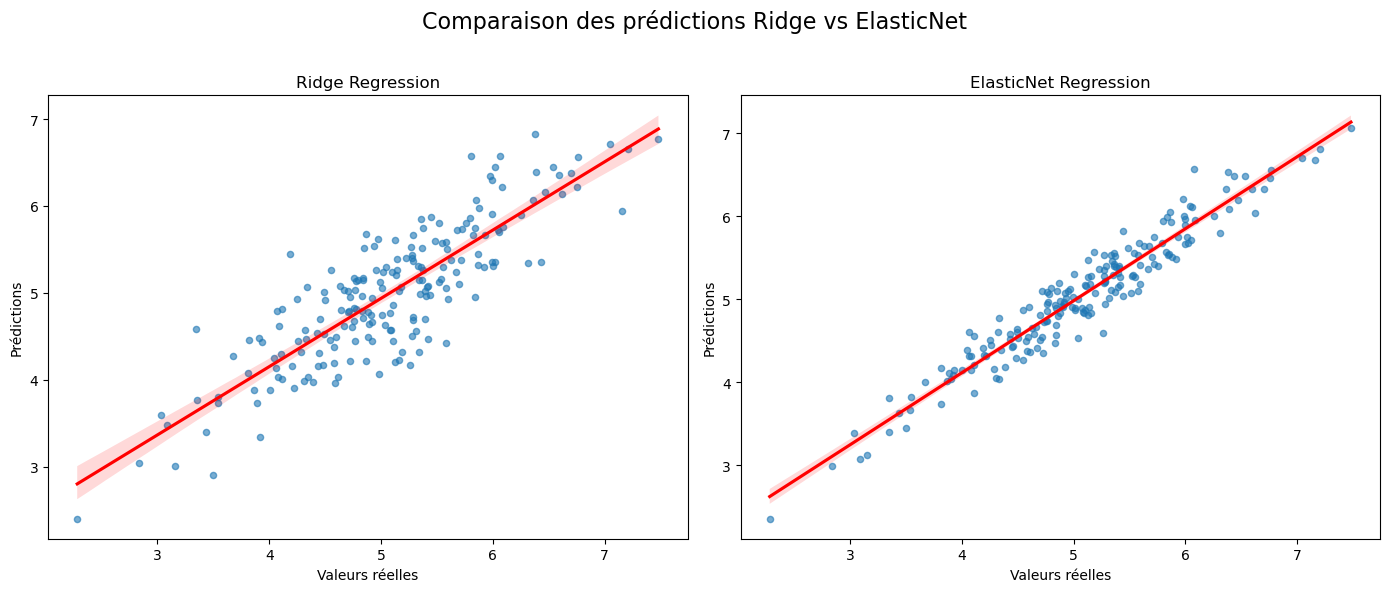

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results_df = pd.DataFrame({
    'y_test': y_test.flatten(),
    'Ridge': ridge_pred.flatten(),
    'ElasticNet': elastic_pred.flatten()
})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Comparaison des prédictions Ridge vs ElasticNet", fontsize=16)

sns.regplot(
    x='y_test', y='Ridge', data=results_df,
    ax=axes[0], scatter_kws={'s': 20, 'alpha': 0.6}, line_kws={'color': 'red'}
)
axes[0].set_title("Ridge Regression")
axes[0].set_xlabel("Valeurs réelles")
axes[0].set_ylabel("Prédictions")

sns.regplot(
    x='y_test', y='ElasticNet', data=results_df,
    ax=axes[1], scatter_kws={'s': 20, 'alpha': 0.6}, line_kws={'color': 'red'}
)
axes[1].set_title("ElasticNet Regression")
axes[1].set_xlabel("Valeurs réelles")
axes[1].set_ylabel("Prédictions")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Le schéma ci-dessus présente une comparaison visuelle des performances des modèles de régression Ridge (à gauche) et ElasticNet (à droite) en traçant les prédictions obtenues en fonction des valeurs réelles de la variable cible. On observe que dans les deux cas, les points s’alignent globalement bien le long de la diagonale idéale, ce qui indique que les prédictions sont cohérentes avec les observations. Toutefois, la régression ElasticNet affiche un alignement sensiblement plus précis et plus resserré autour de la droite rouge, traduisant une meilleure capacité du modèle à capturer la relation entre les variables explicatives et la cible. Cela confirme les résultats numériques obtenus précédemment, avec un score R² plus élevé pour ElasticNet (0.9226) comparé à Ridge (0.7146). On peut en conclure que dans ce contexte, l’introduction de la régularisation mixte (L1 + L2) via ElasticNet permet une meilleure généralisation, probablement en favorisant une sélection plus pertinente des variables tout en limitant le surapprentissage.